In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *

In [2]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cuda:0 NVIDIA GeForce GTX 1650 Ti


Select varables for model

**Sequential**  
use_sigmoid = False

**Independent**  
use_sigmoid = True

**Join without sig**  
use_sigmoid = False

**Joint with sig**  
use_sigmoid = True

In [4]:
use_relu = False
use_sigmoid = True
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [5]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

test_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", "rb"))
test_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", 16, image_dir='dataset/CUB/data/images')
train_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/independant_seed1.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [6]:
attr_count = []
for i in range(N_CONCEPT):
    attr_count.append(0)

Print a list of the count of occurances for each concept

In [7]:
for sample in test_split:
    for idx, attr in enumerate(sample["attribute_label"]):
        if attr == 1:
            attr_count[idx] = attr_count[idx] + 1

print(attr_count)

[499, 338, 2382, 1408, 1432, 1337, 357, 2361, 1174, 763, 1352, 1564, 477, 2350, 1018, 735, 354, 551, 832, 892, 2479, 852, 3761, 420, 477, 1324, 1496, 299, 1535, 690, 644, 1688, 996, 1062, 1738, 689, 492, 289, 1268, 384, 490, 857, 929, 2133, 715, 286, 620, 1141, 2123, 376, 5596, 1989, 3635, 293, 818, 676, 443, 1943, 482, 887, 880, 2237, 911, 492, 747, 964, 354, 1293, 1070, 496, 313, 471, 862, 716, 2361, 676, 2481, 874, 3677, 1051, 566, 286, 3496, 2871, 705, 405, 2477, 388, 767, 4342, 1105, 1265, 742, 1595, 1171, 536, 1250, 1626, 635, 744, 2860, 316, 293, 847, 676, 323, 1915, 422, 1532, 283, 1164, 1295]


In [8]:
def generateClassMatrix(dataloader, model, device):
    nb_classes = 200
    model.eval()

    confusion_matrix = torch.zeros(nb_classes, nb_classes, dtype=torch.int32)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            _, preds = torch.max(predictions[0], 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.item(), p.item()] += 1

    return confusion_matrix

In [9]:
IMG_SIZE =  299
training_transform = transforms.Compose([
    transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

other_transform = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

## Per class accuracy

In [10]:
matrix = generateClassMatrix(test_loader, XtoCtoY_model, device)

print("Test accuracy")
print("=============")
print(str(torch.mean(matrix.diag()/matrix.sum(1)).item() * 100) + "%")
print("")
print("Per class accuracy")
print("==================")
for i, acc in enumerate(matrix.diag()/matrix.sum(1)):
    print(class_index_to_string(i) + ":", str(acc.item() * 100) + "%")
print("")
print("Confusion materix")
print("=================")
print(matrix)

Test accuracy
77.59515643119812%

Per class accuracy
Black_footed_Albatross: 73.33333492279053%
Laysan_Albatross: 73.33333492279053%
Sooty_Albatross: 92.85714030265808%
Groove_billed_Ani: 43.33333373069763%
Crested_Auklet: 85.71428656578064%
Least_Auklet: 90.90909361839294%
Parakeet_Auklet: 91.30434989929199%
Rhinoceros_Auklet: 72.22222089767456%
Brewer_Blackbird: 31.034481525421143%
Red_winged_Blackbird: 89.99999761581421%
Rusty_Blackbird: 53.33333611488342%
Yellow_headed_Blackbird: 80.7692289352417%
Bobolink: 96.66666388511658%
Indigo_Bunting: 93.33333373069763%
Lazuli_Bunting: 92.85714030265808%
Painted_Bunting: 92.85714030265808%
Cardinal: 96.29629850387573%
Spotted_Catbird: 93.33333373069763%
Gray_Catbird: 68.96551847457886%
Yellow_breasted_Chat: 79.31034564971924%
Eastern_Towhee: 96.66666388511658%
Chuck_will_Widow: 61.538463830947876%
Brandt_Cormorant: 68.96551847457886%
Red_faced_Cormorant: 50.0%
Pelagic_Cormorant: 56.66666626930237%
Bronzed_Cowbird: 73.33333492279053%
Shiny_Co

## Per concept accuracy

Concepts are also put into groups

In [22]:
"""
Note: making a matrix does not really work for concepts. All the values in the matrix will always follow the diaganal.
* If the prediction was correct it will add to the diaganal (as we would want)
* If the prediction was incorrect it will add to the diaginal and there is no clear way to add to another column (perhaps not possible??)
* If the preduction was missed then it will add to the diaginal.

A better solutin (for now): Create a number of lists for correct predictions, missed predictions and incorrect predictions
"""
def generateConceptMatrix(dataloader, model, device):
    nb_concepts = N_CONCEPT
    model.eval()

    confusion_matrix = torch.zeros(nb_concepts, nb_concepts, dtype=torch.int32)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            images, labels, concepts = next(iter(dataloader))
            images, concepts = images.to(device), concepts.to(device)
            predictions = model.first_model(images)
            predictions = torch.nn.Sigmoid()(torch.cat(predictions, dim=1))
            for item_index, pred_vector in enumerate(predictions):
                #print(pred_vector)
                acc_vector = []
                for pred_concept in pred_vector:
                    if pred_concept.item() >= 0.5:
                        acc_vector.append(1)
                    else:
                        acc_vector.append(0)
                for idx, (t, p) in enumerate(zip(concepts[item_index].view(-1), acc_vector)):
                    if int(t.item()) == 1 or p == 1:
                        confusion_matrix[idx, idx] += 1

    return confusion_matrix

In [23]:
def getConceptPredictionLists(dataloader, model, device):
    nb_concepts = N_CONCEPT
    model.eval()
    
    correct_count = []
    incorrect_count = []
    missed_count = []
    for i in range(nb_concepts):
        correct_count.append(0)
        incorrect_count.append(0)
        missed_count.append(0)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            #images, labels, concepts = next(iter(dataloader))
            images, concepts = images.to(device), concepts.to(device)
            predictions = model(images)
            _, class_preds = torch.max(predictions[0], 1)
            concept_preds = torch.nn.Sigmoid()(predictions[1])
            for item_index, pred_vector in enumerate(concept_preds):
                #print(pred_vector.size(), item_index)
                #print(pred_vector)
                acc_vector = []
                for pred_concept in pred_vector:
                    if pred_concept.item() >= 0.5:
                        acc_vector.append(1)
                    else:
                        acc_vector.append(0)
                # idx == concept index, t == true concepts from the dataset, p == predicted concepts
                for idx, (t, p) in enumerate(zip(concepts[item_index].view(-1), acc_vector)):
                    if int(t.item()) == 1 and p == 1:
                        correct_count[idx] += 1
                    elif int(t.item()) == 1:
                        missed_count[idx] += 1
                    elif p == 1:
                        incorrect_count[idx] += 1
                    else:
                        "something went wrong! Cannot work out if prediction was correct, incorrect or missed"
                

    return correct_count, missed_count, incorrect_count

In [13]:
correct_count, missed_count, incorrect_count = getConceptPredictionLists(test_loader, XtoCtoY_model, device)
print("done")

done


In [14]:
import pandas as pd

In [15]:
def set_concept_group(row):
    if 'shape' in row.name:
        val = 'shape'
    elif 'color' in row.name:
        val = 'colour'
    elif 'pattern' in row.name:
        val = 'pattern'
    else:
        val = 'size_length'
    return val

In [16]:
d = {'concept': [concept_index_to_string(x) for x in range(N_CONCEPT)], 'true_concept_count': attr_count, 'correctly_predicted_concepts': correct_count, 'incorrectly_predicted_concepts': incorrect_count, 'missing_concept_predictions': missed_count}
df = pd.DataFrame(data=d).set_index('concept')
df['accuracy'] = df.apply(lambda row: round(100 * (row.correctly_predicted_concepts / row.true_concept_count), 3), axis=1)
df['concept_group'] = df.apply(set_concept_group, axis=1)

In [17]:
with pd.option_context('expand_frame_repr', False, 'display.max_rows', None):
    print(df.sort_values(by=['concept'], ascending=False))
    
print(f"concept accuracy: {(df['correctly_predicted_concepts'].sum()/df['true_concept_count'].sum()) *100}%")

                                         true_concept_count  correctly_predicted_concepts  incorrectly_predicted_concepts  missing_concept_predictions  accuracy concept_group
concept                                                                                                                                                                       
has_wing_shape::rounded-wings                          2481                          2291                             195                          190    92.342         shape
has_wing_shape::pointed-wings                           874                           719                              71                          155    82.265         shape
has_wing_pattern::striped                              1164                          1072                              90                           92    92.096       pattern
has_wing_pattern::spotted                               283                           253                               3    

## Plot concept group accuracy 

<Figure size 432x288 with 0 Axes>

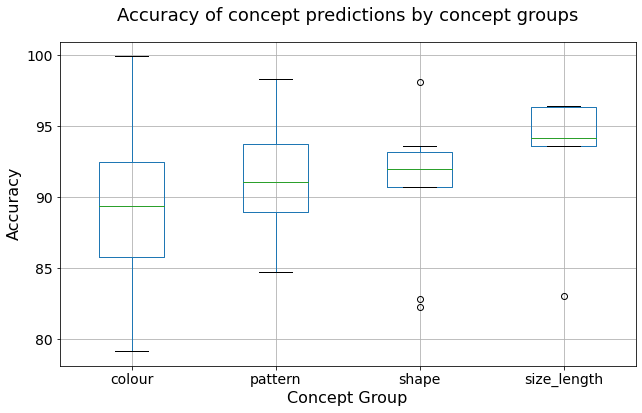

In [24]:
plt.figure()
df.boxplot(by="concept_group", column=['accuracy'], figsize=(10, 6), fontsize=14)
plt.xlabel('Concept Group', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.suptitle('Accuracy of concept predictions by concept groups', fontsize=18)
plt.title('')
plt.show()